In [ ]:
#import packages

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
# import tensorflow.keras as keras
# import tensorflow.keras.layers as layers
# from tensorflow.keras.applications.resnet_v2 import ResNet101V2
import tensorflow_hub as hub


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# !ls /content/drive/MyDrive/CIP/

Mounted at /content/drive


In [ ]:
# Set the image size
IMAGE_SIZE = 240

In [ ]:
base_path = "/content/drive/MyDrive/CIP/"
labels = ["edible", "poisonous"]

# Directories containing images for each category
directory_group = [
    ["edible mushroom sporocarp", "edible sporocarp"],
    ["poisonous mushroom sporocarp", "poisonous sporocarp"]
]

edible_fungus = []
poisonous_fungus = []

# Define file paths for images in each category and add them to the corresponding list
for label, directories in zip(labels, directory_group):
    for directory in directories:
        path = os.path.join(base_path, directory)
        for file in os.listdir(path):
            file_path = os.path.join(base_path, directory, file)
            if label == "edible":
                edible_fungus.append(file_path)
            else:
                poisonous_fungus.append(file_path)

# Convert the file paths and labels to tensors separately
edible_fungus = tf.constant(edible_fungus)
edible_labels = tf.constant([0] * len(edible_fungus))
poisonous_fungus = tf.constant(poisonous_fungus)
poisonous_labels = tf.constant([1] * len(poisonous_fungus))

# Combine the tensors for edible and poisonous fungus into a single tensor
fungus_paths = tf.concat([edible_fungus, poisonous_fungus], axis=0)
fungus_labels = tf.concat([edible_labels, poisonous_labels], axis=0)

# Define batch size
batch_size = 32


In [ ]:
def preprocess_image(image_path, label):
    # Read image file as a string
    image_string = tf.io.read_file(image_path)
    
    # Decode the image based on the file type using a conditional statement
    image_decoded = tf.cond(
        tf.image.is_jpeg(image_string),  # Check if the image is a JPEG
        lambda: tf.image.decode_jpeg(image_string, channels=3),  # Decode as JPEG, JPG
        lambda: tf.image.decode_png(image_string, channels=3)    # Decode as PNG
    )
    
    # Resize the decoded image
    image_resized = tf.image.resize(image_decoded, (IMAGE_SIZE, IMAGE_SIZE))
    
    # Normalize the image pixels to be in the range [0, 1]
    image_normalized = tf.cast(image_resized, tf.float32) / 255.0
    
    # Convert the label to an integer
    label = tf.cast(label, tf.int64)
    
    return image_normalized, label

In [ ]:
def augment_image(image_path, label):
    # Read image file
    image = tf.io.read_file(image_path)

    # Decode the image based on the file type using a conditional statement
    image_decoded = tf.cond(
        tf.image.is_jpeg(image_string),  # Check if the image is a JPEG
        lambda: tf.image.decode_jpeg(image_string, channels=3),  # Decode as JPEG, JPG
        lambda: tf.image.decode_png(image_string, channels=3)    # Decode as PNG
    )

    # Resize image
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])

    # Randomly flip the image horizontally
    image = tf.image.random_flip_left_right(image)

    # Randomly adjust brightness of the image
    image = tf.image.random_brightness(image, max_delta=0.1)

    # Normalize pixel values to range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0

    return image, label



In [ ]:
def _decode_image(image):
    # Decode the image
    image_decoded = tf.image.decode_jpeg(image, channels=3)
    # Normalize pixel values
    image_normalized = tf.cast(image_decoded, tf.float32) / 255.0
    # Resize the image to (224, 224)
    image_resized = tf.image.resize(image_normalized, [IMAGE_SIZE, IMAGE_SIZE])
    return image_resized


In [ ]:
def get_dataset(image_paths, labels, batch_size, validation_split=0.2, test_split=0.1):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.shuffle(buffer_size=len(image_paths))

    # Split into train, validation and test datasets
    val_size = int(len(image_paths) * validation_split)
    test_size = int(len(image_paths) * test_split)
    train_size = len(image_paths) - val_size - test_size
    train_dataset = dataset.take(train_size)
    remaining_dataset = dataset.skip(train_size)
    test_dataset = remaining_dataset.take(test_size)
    valid_dataset = remaining_dataset.skip(test_size)

    # Apply augmentation function to train dataset
    # train_dataset = train_dataset.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

    # Apply preprocessing to validation and test datasets
    preprocess = lambda image, label: (_decode_image(image), label)
    valid_dataset = valid_dataset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    valid_dataset = valid_dataset.batch(batch_size)
    valid_dataset = valid_dataset.prefetch(tf.data.experimental.AUTOTUNE)

    test_dataset = test_dataset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.batch(batch_size)
    test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return train_dataset, valid_dataset, test_dataset


# Model Development

In [ ]:
# Get datasets
train_dataset, valid_dataset, test_dataset = get_dataset(fungus_paths, fungus_labels, batch_size, 0.2, 0.1)


In [ ]:
# Load the pre-trained ResNet model
module_handle = "https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/5"
model = tf.keras.Sequential([
    hub.KerasLayer(module_handle, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), trainable=False),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

# Train the model
history = model.fit(train_dataset, epochs=20, validation_data=valid_dataset)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              42626560  
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 42,628,609
Trainable params: 2,049
Non-trainable params: 42,626,560
_________________________________________________________________


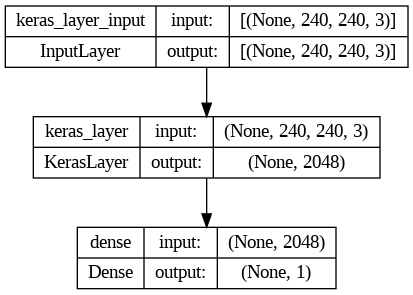

In [ ]:
# Print the model summary
model.summary()

# Plot the model
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Plot the training and validation accuracy
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

In [ ]:
# Save the model to Google Drive
model_path = '/content/drive/MyDrive/model'
tf.keras.models.save_model(model, model_path, save_format='tf')


In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

In [ ]:
# Demo Prediction 
import tensorflow as tf
import numpy as np
import cv2

# Define the path to the saved model
model_path = '/content/drive/MyDrive/model'

# Load the saved model
model = tf.keras.models.load_model(model_path)

In [ ]:
# Define the image path
image_path = '/content/LionsMane.jpeg'

# Read the image
image = cv2.imread(image_path)

# Resize the image to the size expected by the model
image_resized = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

# Preprocess the image by scaling its pixel values between 0 and 1
image_normalized = image_resized / 255.0

# Add an extra dimension to the image to represent the batch size (1 in this case)
image_batch = np.expand_dims(image_normalized, axis=0)


# Use the model to make a prediction on the image batch
prediction = model.predict(image_batch)

# Get the class with the highest probability
class_index = np.argmax(prediction)

# Print the predicted class
class_names = ['edible', 'poisonous']
predicted_class_name = class_names[class_index]
print('The predicted class is', predicted_class_name)
print(f"The predicted class is {class_index}")

1/1 [==============================] - 0s 27ms/step
The predicted class is edible
The predicted class is 0


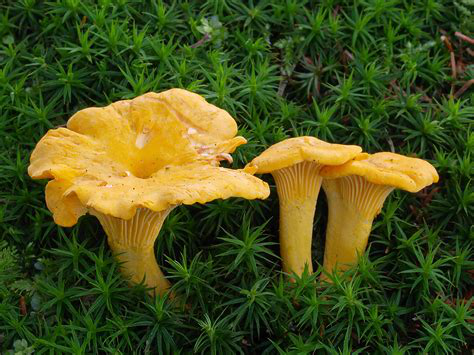

In [ ]:
from PIL import Image
image = Image.open(image_path)

# Display the image
image.show()


In [ ]:
# # Load an image
# image_path = "/content/th-1691558308.jpeg"
# image = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
# image_array = tf.keras.preprocessing.image.img_to_array(image)
# image_array = tf.expand_dims(image_array, 0)  # Create a batch of 1 image

# # Use the model to make a prediction on the image batch
# prediction = model.predict(image_batch)

# # Get the class with the highest probability
# class_index = np.argmax(prediction)

# class_names = ['edible', 'poisonous']
# predicted_class_name = class_names[class_index]
# print('The predicted class is', predicted_class_name)

# # Print the predicted class
# print(f"The predicted class is {class_index}")